In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
df = pd.read_excel("DataCore.xlsx")

In [28]:
df

,YEAR,BANK,CUS,ROA,ROE,NIM,DEP,CASH,LGAP,NPL,SIZE,CR3,VCSH,RRTD,GDP,INF
0,2018,ABB,ABB2018,0.008194,0.110093,0.032627,0.761632,0.139490,-0.190148,0.023422,18.284294,0.437586,0.074426,0.006374,0.070758,0.035394
1,2009,ABB,ABB2009,0.015578,0.073807,0.043999,0.742687,0.462718,-0.198323,0.024272,16.811548,0.443493,0.211059,0.007698,0.053979,0.070546
2,2017,ABB,ABB2017,0.006161,0.081738,0.037870,0.780668,0.197173,-0.222004,0.027180,18.189219,0.452310,0.075381,0.011413,0.068122,0.035203
3,2010,ABB,ABB2010,0.015376,0.108547,0.047665,0.788100,0.298168,-0.242703,0.013691,17.289552,0.402135,0.141657,0.005776,0.064232,0.088616
4,2011,ABB,ABB2011,0.007719,0.065501,0.065404,0.747739,0.232049,-0.243431,0.019986,17.498845,0.383013,0.117843,0.029036,0.062403,0.186755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2013,VPB,VPB2013,0.009088,0.131702,0.059327,0.732269,0.135112,-0.311674,0.028029,18.533730,0.414936,0.064464,0.023214,0.054219,0.065923
317,2012,VPB,VPB2012,0.006937,0.095899,0.049344,0.701148,0.311961,-0.314903,0.023484,18.345370,0.418736,0.068496,0.012231,0.052474,0.090942
318,2017,VTB,VTB2017,0.006710,0.078832,0.023821,0.878382,0.135369,-0.146414,0.014735,17.482040,0.452310,0.081758,0.001782,0.068122,0.035203
319,2018,VTB,VTB2018,0.006909,0.071444,0.027318,0.865519,0.181519,-0.164647,0.013055,17.657171,0.437586,0.084073,0.002491,0.070758,0.035394


In [29]:
df = df.rename(columns={'INF': 'INFLATION'})
df.drop(['ROE', 'NIM','CUS'], axis=1, inplace=True)

In [30]:
df

,YEAR,BANK,ROA,DEP,CASH,LGAP,NPL,SIZE,CR3,VCSH,RRTD,GDP,INFLATION
0,2018,ABB,0.008194,0.761632,0.139490,-0.190148,0.023422,18.284294,0.437586,0.074426,0.006374,0.070758,0.035394
1,2009,ABB,0.015578,0.742687,0.462718,-0.198323,0.024272,16.811548,0.443493,0.211059,0.007698,0.053979,0.070546
2,2017,ABB,0.006161,0.780668,0.197173,-0.222004,0.027180,18.189219,0.452310,0.075381,0.011413,0.068122,0.035203
3,2010,ABB,0.015376,0.788100,0.298168,-0.242703,0.013691,17.289552,0.402135,0.141657,0.005776,0.064232,0.088616
4,2011,ABB,0.007719,0.747739,0.232049,-0.243431,0.019986,17.498845,0.383013,0.117843,0.029036,0.062403,0.186755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2013,VPB,0.009088,0.732269,0.135112,-0.311674,0.028029,18.533730,0.414936,0.064464,0.023214,0.054219,0.065923
317,2012,VPB,0.006937,0.701148,0.311961,-0.314903,0.023484,18.345370,0.418736,0.068496,0.012231,0.052474,0.090942
318,2017,VTB,0.006710,0.878382,0.135369,-0.146414,0.014735,17.482040,0.452310,0.081758,0.001782,0.068122,0.035203
319,2018,VTB,0.006909,0.865519,0.181519,-0.164647,0.013055,17.657171,0.437586,0.084073,0.002491,0.070758,0.035394


In [31]:
df.describe(include='all')

,YEAR,BANK,ROA,DEP,CASH,LGAP,NPL,SIZE,CR3,VCSH,RRTD,GDP,INFLATION
count,321.000000,321,321.000000,321.000000,321.000000,321.000000,3.210000e+02,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
unique,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,ABB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2013.074766,NaN,0.009021,0.750049,0.220640,-0.206748,2.231160e-02,18.003507,0.433995,0.105141,0.010970,0.061104,0.079406
std,3.133591,NaN,0.008355,0.080868,0.126600,0.122962,1.252841e-02,1.232005,0.032109,0.051797,0.009056,0.005912,0.063837
min,2008.000000,NaN,-0.059929,0.429914,0.047361,-0.698198,5.802364e-08,14.497839,0.383013,0.033521,-0.013367,0.052474,0.008786
25%,2010.000000,NaN,0.004248,0.694157,0.132856,-0.283034,1.400164e-02,17.043560,0.414936,0.071142,0.005068,0.054219,0.035203
50%,2013.000000,NaN,0.007743,0.757334,0.188523,-0.214794,2.087028e-02,18.056905,0.437586,0.089842,0.008486,0.062108,0.065923
75%,2016.000000,NaN,0.013239,0.812826,0.297587,-0.137525,2.759999e-02,18.921398,0.447359,0.127655,0.015015,0.066793,0.090942


In [32]:
bien_doc_lap = ['DEP','CASH','LGAP','NPL','SIZE', 'CR3','VCSH', 'RRTD','GDP', 'INFLATION']
bien_phu_thuoc = ['ROA']
danh_sach_bien = ['ROA','DEP','CASH','LGAP','NPL','SIZE', 'CR3','VCSH', 'RRTD','GDP', 'INFLATION']

In [33]:
#phân tích ma trận tự tương quan của các biến độc lập
corr_matrix = df[bien_doc_lap].corr()
corr_matrix

,DEP,CASH,LGAP,NPL,SIZE,CR3,VCSH,RRTD,GDP,INFLATION
DEP,1.000000,-0.186539,-0.355814,-0.098082,0.097023,0.242743,-0.348368,-0.082261,0.281790,-0.262631
CASH,-0.186539,1.000000,-0.315253,-0.069681,-0.285094,-0.033886,0.200345,-0.206238,-0.276921,0.386699
LGAP,-0.355814,-0.315253,1.000000,-0.055362,0.073569,0.011658,0.175071,0.065349,0.027177,0.016706
NPL,-0.098082,-0.069681,-0.055362,1.000000,-0.062203,-0.143919,0.097168,0.117686,-0.272114,-0.074901
SIZE,0.097023,-0.285094,0.073569,-0.062203,1.000000,-0.096853,-0.748807,0.160987,0.302338,-0.350440
CR3,0.242743,-0.033886,0.011658,-0.143919,-0.096853,1.000000,0.062530,0.018306,-0.018331,0.154719
VCSH,-0.348368,0.200345,0.175071,0.097168,-0.748807,0.062530,1.000000,0.042370,-0.295563,0.290298
RRTD,-0.082261,-0.206238,0.065349,0.117686,0.160987,0.018306,0.042370,1.000000,0.060827,-0.136658
GDP,0.281790,-0.276921,0.027177,-0.272114,0.302338,-0.018331,-0.295563,0.060827,1.000000,-0.371005
INFLATION,-0.262631,0.386699,0.016706,-0.074901,-0.350440,0.154719,0.290298,-0.136658,-0.371005,1.000000


Text(0.5, 1.0, 'Bảng kết quả phân tích tự tương quan của các biến độc lập trong mô hình')

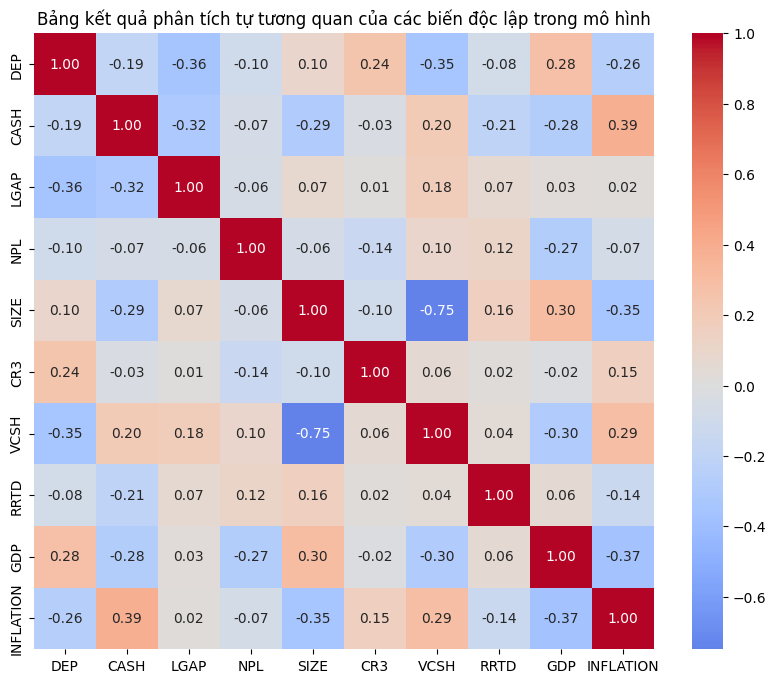

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Bảng kết quả phân tích tự tương quan của các biến độc lập trong mô hình')

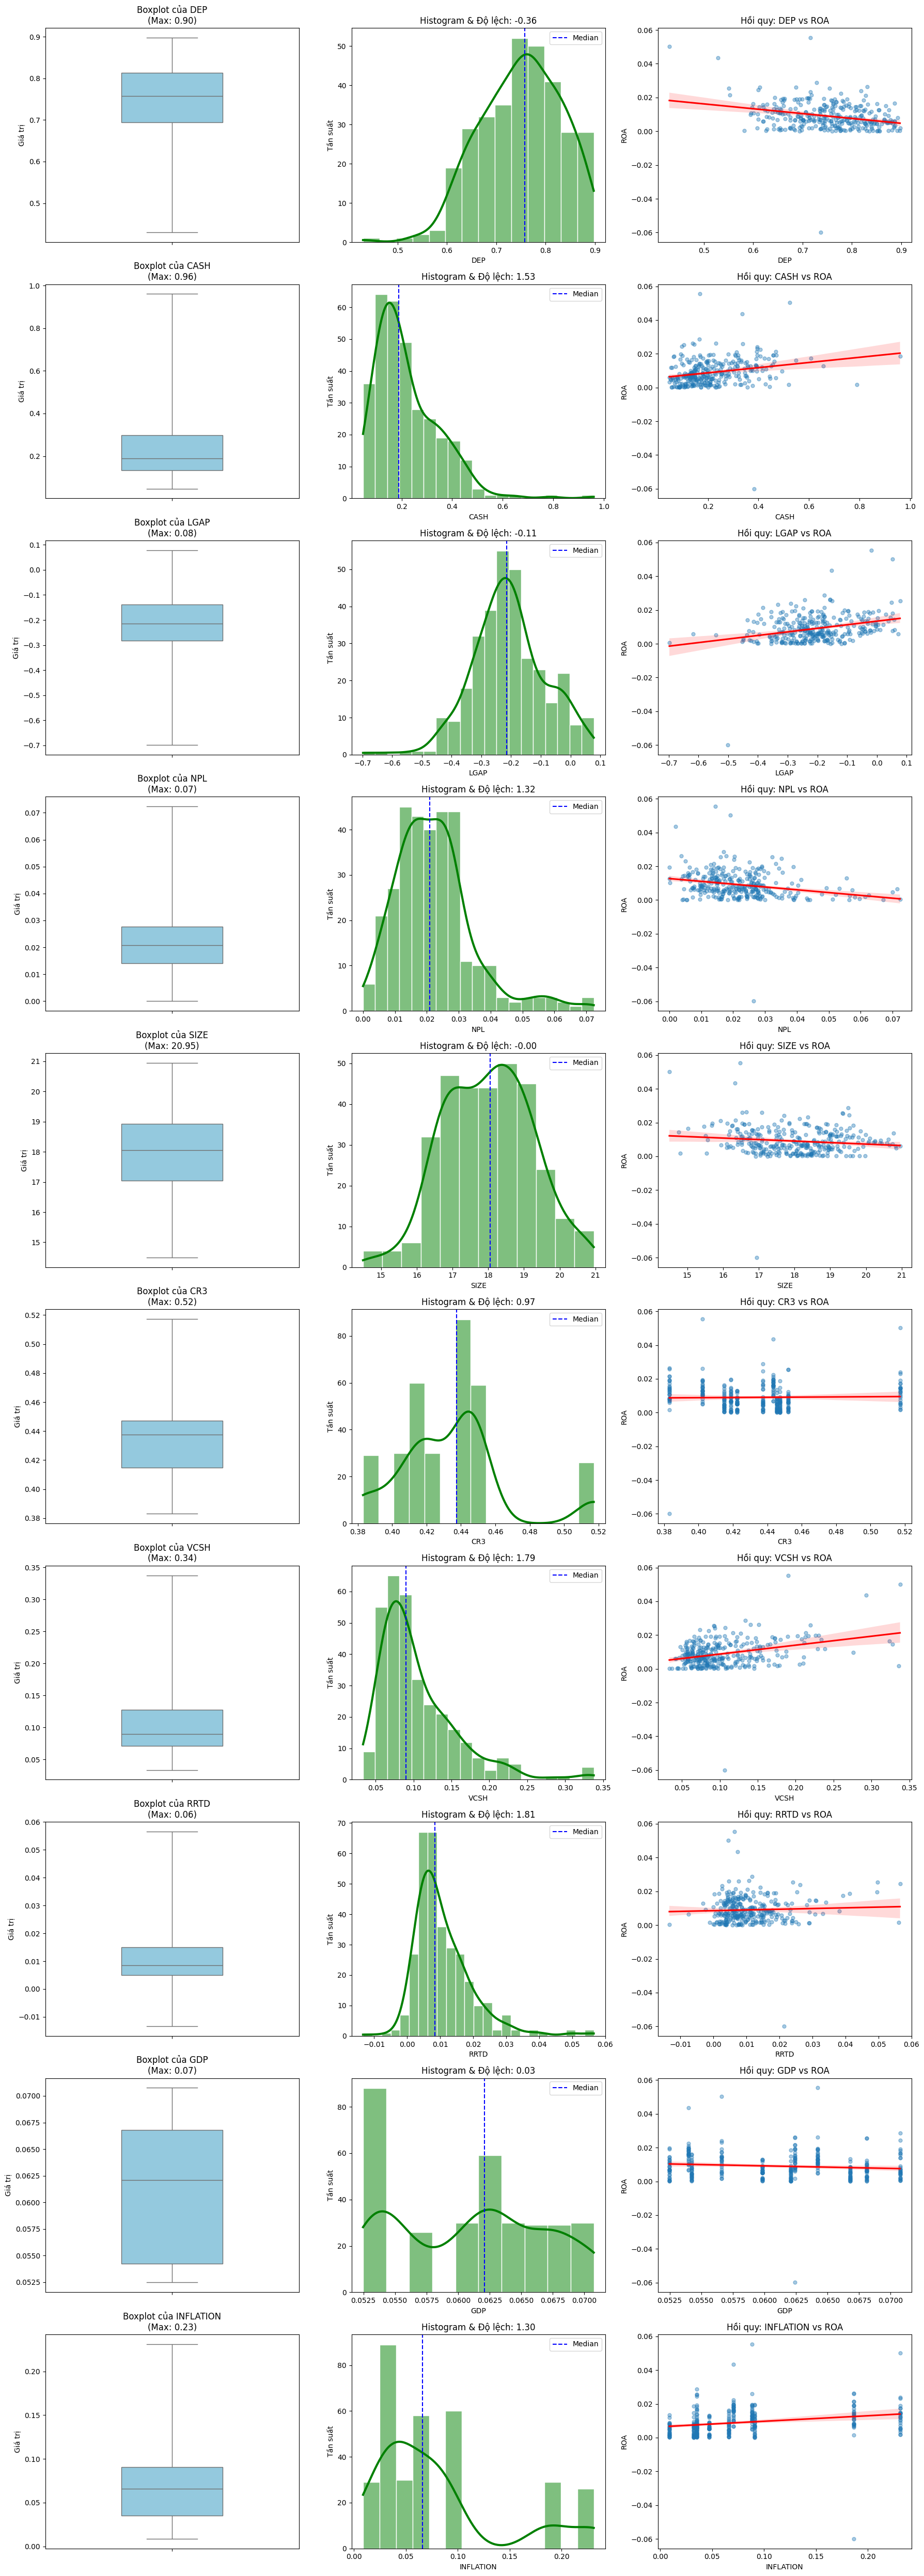

In [35]:
y_bien = 'ROA'
n = len(bien_doc_lap)

# Tạo Figure: n hàng, 3 cột
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(18, n * 5))

if n == 1:
    axes = axes.reshape(1, -1)

for i, col in enumerate(bien_doc_lap):
    # Tính toán các chỉ số
    s_val = df[col].skew()
    max_val = df[col].max()

    # 1. Boxplot dọc (Cột 0) - Hiển thị râu đến Max tuyệt đối
    sns.boxplot(y=df[col], ax=axes[i, 0], color='skyblue', width=0.4, whis=(0, 100))
    axes[i, 0].set_title(f'Boxplot của {col}\n(Max: {max_val:.2f})')
    axes[i, 0].set_ylabel('Giá trị')

    # 2. Histogram thực thụ (Cột 1) - Thể hiện độ lệch
    sns.histplot(df[col], kde=True, ax=axes[i, 1], color='green',
                 bins='auto',           # Tự động tính số cột tối ưu
                 edgecolor='white',    # Thêm viền trắng giữa các cột cho rõ ràng
                 line_kws={'linewidth': 3}) # Làm đậm đường cong KDE

    axes[i, 1].set_title(f'Histogram & Độ lệch: {s_val:.2f}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Tần suất')
    # Đường Median (Trung vị) để đối chiếu độ lệch
    axes[i, 1].axvline(df[col].median(), color='blue', linestyle='--', label='Median')
    axes[i, 1].legend()

    # 3. Regplot (Cột 2) - Mối quan hệ với ROA
    sns.regplot(data=df, x=col, y=y_bien, ax=axes[i, 2],
                scatter_kws={'alpha':0.4, 's':25},
                line_kws={'color':'red'})
    axes[i, 2].set_title(f'Hồi quy: {col} vs {y_bien}')
    axes[i, 2].set_xlabel(col)
    axes[i, 2].set_ylabel(y_bien)
plt.tight_layout()


In [36]:
# thực hiện kiểm định đa cộng tuyến
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

def check_vif_final(df, bien_doc_lap):
    # 1. Chuẩn bị dữ liệu
    X = df[bien_doc_lap].dropna()
    X_with_const = add_constant(X)

    # 2. Tính VIF và làm tròn
    vif_data = pd.DataFrame()
    vif_data["Biến độc lập"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                        for i in range(len(X_with_const.columns))]

    # 3. Lọc bỏ 'const', sắp xếp và làm tròn 2 chữ số
    vif_result = vif_data[vif_data["Biến độc lập"] != "const"].copy()
    vif_result["VIF"] = vif_result["VIF"].round(2)
    vif_result = vif_result.sort_values(by="VIF", ascending=False).reset_index(drop=True)

    # 4. Tính trung bình và làm tròn
    vif_mean = round(vif_result["VIF"].mean(), 2)

    # 5. Thêm hàng trung bình
    mean_row = pd.DataFrame([{"Biến độc lập": "--- TRUNG BÌNH ---", "VIF": vif_mean}])
    vif_final = pd.concat([vif_result, mean_row], ignore_index=True)

    return vif_final


vif_table = check_vif_final(df, bien_doc_lap)
print(vif_table)

          Biến độc lập   VIF
0                 VCSH  3.12
1                 SIZE  3.01
2                  DEP  1.72
3                 CASH  1.55
4                 LGAP  1.52
5            INFLATION  1.50
6                  GDP  1.42
7                  NPL  1.19
8                  CR3  1.18
9                 RRTD  1.16
10  --- TRUNG BÌNH ---  1.74


In [37]:
# Thực hiện các kiểm định để lựa chọn mô hình hồi quy phù hợp trong các mô hình: Pooled OLS, FEM (Fixed Effects), REM (Random Effects)
## Bước 1: Kiểm định F-test (So sánh Pooled OLS và Fixed Effects - Kiểm định này xem xét liệu có sự khác biệt đặc thù giữa các đơn vị quan sát hay không.)
## Giả thuyết Ho: Mô hình Pooled OLS là phù hợp (không có đặc điểm riêng biệt giữa các đơn vị).
### Nếu p-value < 0.05: Bác bỏ Ho:, chọn mô hình Fixed Effects (FE).
### Nếu p-value > 0.05: Chọn Pooled OLS
from linearmodels import PooledOLS, PanelOLS, RandomEffects
import statsmodels.api as sm

# 1. Chuẩn bị dữ liệu
df_panel = df.set_index(['BANK', 'YEAR'])
exog = sm.add_constant(df_panel[bien_doc_lap])
endog = df_panel['ROA']

# 2. Chạy các mô hình
mod_pooled = PooledOLS(endog, exog).fit()
mod_fe = PanelOLS(endog, exog, entity_effects=True).fit()
mod_re = RandomEffects(endog, exog).fit()

# 3. In kết quả để so sánh p-value của các kiểm định đính kèm
print(mod_pooled)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    ROA   R-squared:                        0.3383
Estimator:                  PooledOLS   R-squared (Between):              0.3612
No. Observations:                 321   R-squared (Within):               0.3372
Date:                Sat, Jan 31 2026   R-squared (Overall):              0.3383
Time:                        11:16:08   Log-likelihood                    1147.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      15.849
Entities:                          31   P-value                           0.0000
Avg Obs:                       10.355   Distribution:                  F(10,310)
Min Obs:                       3.0000                                           
Max Obs:                       11.000   F-statistic (robust):             15.849
                            

In [38]:
print(mod_fe) # Xem F-test for individual effects

                          PanelOLS Estimation Summary                           
Dep. Variable:                    ROA   R-squared:                        0.3837
Estimator:                   PanelOLS   R-squared (Between):             -0.4588
No. Observations:                 321   R-squared (Within):               0.3837
Date:                Sat, Jan 31 2026   R-squared (Overall):              0.2262
Time:                        11:16:08   Log-likelihood                    1191.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      17.430
Entities:                          31   P-value                           0.0000
Avg Obs:                       10.355   Distribution:                  F(10,280)
Min Obs:                       3.0000                                           
Max Obs:                       11.000   F-statistic (robust):             17.430
                            

In [39]:
print(mod_re)

                        RandomEffects Estimation Summary                        
Dep. Variable:                    ROA   R-squared:                        0.3390
Estimator:              RandomEffects   R-squared (Between):              0.2911
No. Observations:                 321   R-squared (Within):               0.3510
Date:                Sat, Jan 31 2026   R-squared (Overall):              0.3363
Time:                        11:16:08   Log-likelihood                    1156.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      15.896
Entities:                          31   P-value                           0.0000
Avg Obs:                       10.355   Distribution:                  F(10,310)
Min Obs:                       3.0000                                           
Max Obs:                       11.000   F-statistic (robust):             15.986
                            

In [40]:
# ==============================================================================
# KIỂM ĐỊNH BREUSCH-PAGAN LAGRANGE MULTIPLIER (LM TEST)
# Mục đích: Lựa chọn giữa mô hình Pooled OLS và Random Effects (REM)
# Giả thuyết H0: Phương sai của sai số riêng biệt bằng 0 (Pooled OLS phù hợp).
# Giả thuyết H1: Phương sai của sai số riêng biệt khác 0 (REM phù hợp).
# ==============================================================================
from scipy.stats import chi2

def breusch_pagan_lm_test(residuals, group_variable):
    # Lấy n (số lượng ngân hàng) và T (số năm trung bình)
    n = group_variable.nunique()
    # Tự động tính T dựa trên số lượng mẫu
    T = len(residuals) / n

    # Tính tổng bình phương sai số của Pooled OLS
    sum_sq_residuals = np.sum(residuals**2)

    # Gom nhóm sai số theo Ngân hàng và tính tổng của từng nhóm, sau đó bình phương
    # Lưu ý: residuals từ linearmodels có index là (BANK, YEAR), ta group theo level 0 (BANK)
    grouped_sum = residuals.groupby(level=0).sum()
    sum_grouped_sq = np.sum(grouped_sum**2)

    # Tính thống kê LM
    lm_stat = (n * T / (2 * (T - 1))) * ((sum_grouped_sq / sum_sq_residuals) - 1)**2

    # Tính P-value (với bậc tự do = 1)
    p_value = 1 - chi2.cdf(lm_stat, df=1)

    print("\n--- KIỂM ĐỊNH BREUSCH-PAGAN LM (Pooled OLS vs REM) ---")
    print(f"LM Statistic: {lm_stat:.4f}")
    print(f"P-value:      {p_value:.4f}")

    if p_value < 0.05:
        print("=> Kết luận: Bác bỏ H0. Có hiệu ứng ngẫu nhiên. Mô hình REM phù hợp hơn Pooled OLS.")
    else:
        print("=> Kết luận: Chấp nhận H0. Không có hiệu ứng ngẫu nhiên. Mô hình Pooled OLS phù hợp hơn.")

# Gọi hàm kiểm định
# Lưu ý: mod_pooled.resids là phần dư của mô hình Pooled OLS đã chạy ở trên
breusch_pagan_lm_test(mod_pooled.resids, df['BANK'])


--- KIỂM ĐỊNH BREUSCH-PAGAN LM (Pooled OLS vs REM) ---
LM Statistic: 15.2581
P-value:      0.0001
=> Kết luận: Bác bỏ H0. Có hiệu ứng ngẫu nhiên. Mô hình REM phù hợp hơn Pooled OLS.


In [41]:
# Kiểm định Hausman (So sánh Fixed Effects và Random Effects)
## kiểm tra xem sai số đặc thù có tương quan với các biến độc lập hay không
## Giả thuyết Ho: Mô hình Random Effects (RE) là phù hợp.
### Nếu p-value < 0.05: Bác bỏ Ho, chọn mô hình Fixed Effects (FE).
### Nếu p-value > 0.05: Chọn mô hình Random Effects (RE).
import scipy.stats as stats

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b.shape[0]
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B))
    p_val = stats.chi2.sf(chi2, df)
    return chi2, p_val

chi2, p_val = hausman(mod_fe, mod_re)
print(f"Hausman Test: Chi2 = {chi2:.2f}, p-value = {p_val:.4f}")

Hausman Test: Chi2 = 63.07, p-value = 0.0000


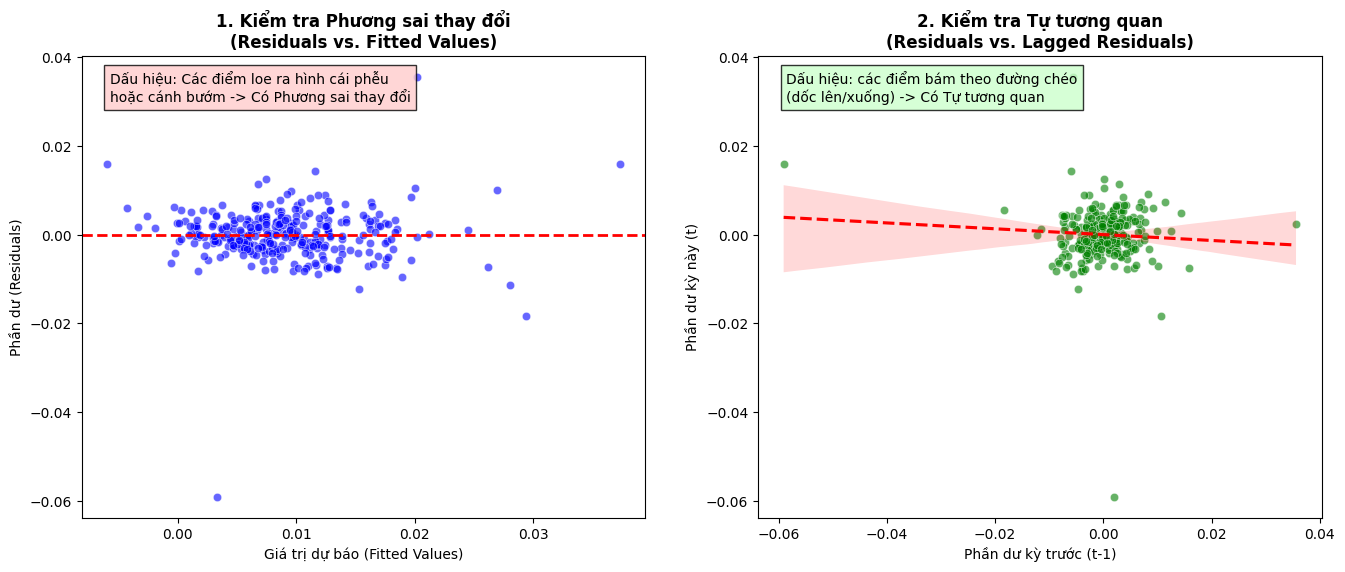

In [51]:
# ==============================================================================
# TRỰC QUAN HÓA KHUYẾT TẬT CỦA MÔ HÌNH FEM
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_model_defects(model_fe):
    """
    Hàm vẽ biểu đồ chẩn đoán khuyết tật mô hình FEM
    """
    # 1. Chuẩn bị dữ liệu
    # Lấy phần dư (residuals) và giá trị dự báo (fitted values)
    # Lưu ý: Với linearmodels, predict() trả về DataFrame, resids là Series
    residuals = model_fe.resids
    fitted_values = model_fe.predict()

    # Tạo DataFrame tạm để xử lý
    plot_data = pd.DataFrame({
        'Residuals': residuals.iloc[:, 0] if isinstance(residuals, pd.DataFrame) else residuals,
        'Fitted_Values': fitted_values.iloc[:, 0]
    })

    # Tạo biến trễ cho phần dư (Lagged Residuals) để check tự tương quan
    # Index của linearmodels là (BANK, YEAR), ta group theo level 0 (BANK) để lag đúng đinh dạng bảng
    plot_data['Lagged_Residuals'] = plot_data.groupby(level=0)['Residuals'].shift(1)

    # 2. Thiết lập khung hình
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))


    # --- BIỂU ĐỒ 1: KIỂM TRA PHƯƠNG SAI SAI SỐ THAY ĐỔI ---
    # Vẽ Scatter plot: Trục hoành là Giá trị dự báo, Trục tung là Phần dư
    sns.scatterplot(x='Fitted_Values', y='Residuals', data=plot_data, ax=axes[0], color='blue', alpha=0.6)
    # Vẽ đường trung bình 0
    axes[0].axhline(0, color='red', linestyle='--', linewidth=2)

    axes[0].set_title('1. Kiểm tra Phương sai thay đổi\n(Residuals vs. Fitted Values)', fontweight='bold')
    axes[0].set_xlabel('Giá trị dự báo (Fitted Values)')
    axes[0].set_ylabel('Phần dư (Residuals)')

    # Ghi chú dấu hiệu nhận biết
    axes[0].text(0.05, 0.90, 'Dấu hiệu: Các điểm loe ra hình cái phễu\nhoặc cánh bướm -> Có Phương sai thay đổi',
                 transform=axes[0].transAxes, fontsize=10, bbox=dict(facecolor='#ffcccc', alpha=0.8))

    # --- BIỂU ĐỒ 2: KIỂM TRA TỰ TƯƠNG QUAN ---
    # Vẽ Scatter plot: Trục hoành là Phần dư kỳ trước, Trục tung là Phần dư kỳ này
    sns.scatterplot(x='Lagged_Residuals', y='Residuals', data=plot_data, ax=axes[1], color='green', alpha=0.6)

    # Vẽ đường hồi quy tuyến tính để thấy rõ xu hướng
    sns.regplot(x='Lagged_Residuals', y='Residuals', data=plot_data, ax=axes[1],
                scatter=False, color='red', line_kws={'linestyle':'--'})

    axes[1].set_title('2. Kiểm tra Tự tương quan\n(Residuals vs. Lagged Residuals)', fontweight='bold')
    axes[1].set_xlabel('Phần dư kỳ trước (t-1)')
    axes[1].set_ylabel('Phần dư kỳ này (t)')

    # Ghi chú dấu hiệu nhận biết
    axes[1].text(0.05, 0.90, 'Dấu hiệu: các điểm bám theo đường chéo\n(dốc lên/xuống) -> Có Tự tương quan',
                 transform=axes[1].transAxes, fontsize=10, bbox=dict(facecolor='#ccffcc', alpha=0.8))

# --- GỌI HÀM ---
# Chạy hàm này ngay sau khi có biến 'mod_fe'
visualize_model_defects(mod_fe)

In [42]:
# Kiểm định các khuyết tật (Diagnostics): Tự tương quan (Autocorrelation) và Phương sai sai số thay đổi (Heteroskedasticity)
# 1. Kiểm định Phương sai sai số thay đổi (Heteroskedasticity)
import statsmodels.stats.api as sms

# Giả sử 'mod_fe' là kết quả từ PanelOLS(endog, exog, entity_effects=True).fit()
def check_heteroskedasticity(model):
    # Lấy phần dư
    residuals = model.resids

    # Kiểm định Breusch-Pagan
    # Cần dùng ma trận biến độc lập từ mô hình
    exog = model.model.exog.values2d
    names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    test = sms.het_breuschpagan(residuals, exog)

    print("--- Kiểm định Phương sai sai số thay đổi (Breusch-Pagan) ---")
    print(dict(zip(names, test)))

    if test[1] < 0.05:
        print("Kết quả: Có hiện tượng Phương sai sai số thay đổi (p < 0.05)")
    else:
        print("Kết quả: Không có hiện tượng Phương sai sai số thay đổi")

check_heteroskedasticity(mod_fe)

--- Kiểm định Phương sai sai số thay đổi (Breusch-Pagan) ---
{'Lagrange multiplier statistic': np.float64(19.270688709250063), 'p-value': np.float64(0.03695621243816782), 'f-value': np.float64(1.9798916698918212), 'f p-value': np.float64(0.03504016805290277)}
Kết quả: Có hiện tượng Phương sai sai số thay đổi (p < 0.05)


In [43]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

def wooldridge_autocorrelation_test(df, y_col, x_cols, entity_col, time_col):
    """
    Thực hiện kiểm định Wooldridge cho tự tương quan trong dữ liệu bảng.
    H0: Không có tự tương quan bậc 1 (First-order autocorrelation).
    H1: Có tự tương quan.
    """
    print(f"\n--- KIỂM ĐỊNH WOOLDRIDGE CHO TỰ TƯƠNG QUAN ---")

    # 1. Sắp xếp dữ liệu và lấy sai phân bậc 1 (First Difference)
    df_sorted = df.sort_values([entity_col, time_col])
    # Gom nhóm theo Entity để tính sai phân đúng
    df_diff = df_sorted.groupby(entity_col)[x_cols + [y_col]].diff().dropna()

    # 2. Hồi quy OLS trên dữ liệu sai phân (Không có hằng số - No Constant)
    # Công thức: D.Y ~ D.X - 1
    # Dùng sm.OLS thay vì formula để dễ xử lý list biến
    model_diff = sm.OLS(df_diff[y_col], df_diff[x_cols], hasconst=False).fit()

    # 3. Lấy phần dư (Residuals)
    residuals = model_diff.resid

    # 4. Tạo biến trễ của phần dư (Lagged Residuals)
    # Cần map phần dư quay lại dataframe có thông tin Entity để lag chính xác
    df_resid = pd.DataFrame({'resid': residuals}, index=df_diff.index)
    # Join lại với df gốc (đã sort) để lấy cột Entity
    df_resid = df_resid.join(df_sorted[[entity_col]])

    # Tạo lag
    df_resid['resid_lag'] = df_resid.groupby(entity_col)['resid'].shift(1)
    df_resid = df_resid.dropna()

    # 5. Hồi quy phần dư theo phần dư trễ
    # Công thức: resid ~ resid_lag
    model_final = smf.ols('resid ~ resid_lag', data=df_resid).fit()

    # 6. Kiểm định giả thuyết H0: Hệ số của resid_lag = -0.5
    # Nếu p-value < 0.05: Bác bỏ H0 -> Có tự tương quan
    # Tự tính F-test hoặc t-test cho giả thuyết Coeff = -0.5
    hypotheses = 'resid_lag = -0.5'
    f_test = model_final.f_test(hypotheses)

    f_stat = f_test.fvalue.item() if hasattr(f_test.fvalue, 'item') else f_test.fvalue
    p_val = f_test.pvalue.item() if hasattr(f_test.pvalue, 'item') else f_test.pvalue

    print(f"F-Statistic: {f_stat:.4f}")
    print(f"P-value:     {p_val:.4f}")

    if p_val < 0.05:
        print("=> Kết luận: Bác bỏ H0. CÓ hiện tượng tự tương quan (Serial Correlation).")
    else:
        print("=> Kết luận: Chấp nhận H0. KHÔNG có hiện tượng tự tương quan.")

    return p_val

wooldridge_autocorrelation_test(df, 'ROA', bien_doc_lap, 'BANK', 'YEAR')


--- KIỂM ĐỊNH WOOLDRIDGE CHO TỰ TƯƠNG QUAN ---
F-Statistic: 9.6275
P-value:     0.0021
=> Kết luận: Bác bỏ H0. CÓ hiện tượng tự tương quan (Serial Correlation).


0.0021308757787742005

In [44]:
## Qua các kết quả kiểm định nêu trên cho thấy mô hình hồi quy theo phương pháp bình phương bé nhất Pooled OLS, FEM là không phù hợp, vì mô hình vi phạm các giả định hồi quy như tự tương quan và phương sai thay đổi. Khi đó sẽ dẫn tới kết quả hồi quy không còn chính xác. Để khắc phục những vi phạm trên bài viết tiếp tục dùng phương pháp bình phương bé nhất tổng quát (GLS) để khắc phục các hiện tượng trên.

In [45]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. Định nghĩa công thức
formula = "ROA ~ DEP + CASH + LGAP + NPL + SIZE + CR3 + VCSH + RRTD + GDP + INFLATION"

# 2. Khởi tạo mô hình GEE
model = smf.gee(formula=formula,
                groups=df["BANK"],
                data=df,
                cov_struct=sm.cov_struct.Exchangeable(),
                family=sm.families.Gaussian())

# 3. Fit mô hình với cov_type='naive'
# 'naive' sẽ tính toán sai số chuẩn dựa trên giả định mô hình (giống xtgls mặc định)
# giúp P-value của INFLATION và SIZE thu nhỏ lại sát với Stata.
results = model.fit(cov_type='naive')

# 4. Hiển thị bảng kết quả
print("--- KẾT QUẢ MÔ HÌNH GLS (GEE) ---")
print(results.summary())

# 5. Kiểm định Wald tổng thể
print("\n--- KIỂM ĐỊNH WALD TỔNG THỂ ---")
print(results.wald_test_terms())

--- KẾT QUẢ MÔ HÌNH GLS (GEE) ---
                               GEE Regression Results                              
Dep. Variable:                         ROA   No. Observations:                  321
Model:                                 GEE   No. clusters:                       31
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  11
Family:                           Gaussian   Mean cluster size:                10.4
Dependence structure:         Exchangeable   Num. iterations:                    11
Date:                     Sat, 31 Jan 2026   Scale:                           0.000
Covariance type:                     naive   Time:                         11:16:09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0022      0.016     -0.138      0.8

C:\Users\Le Tan Phat\PycharmProjects\Python_BA\.venv\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [46]:
# 1. Lấy giá trị dự báo từ mô hình
y_pred = results.predict(df)

# 2. Lấy giá trị thực tế (ROA)
y_actual = df['ROA']

# 3. Tính hệ số tương quan bình phương (tương đương R-squared)
correlation_matrix = np.corrcoef(y_actual, y_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(f"Hệ số xác định R-squared của mô hình là: {r_squared:.4f}")
print(f"Mô hình GLS giải thích được: {r_squared*100:.2f}% sự biến động của ROA")

Hệ số xác định R-squared của mô hình là: 0.3228
Mô hình GLS giải thích được: 32.28% sự biến động của ROA


In [47]:
from sklearn.ensemble import RandomForestRegressor

# 1. Huấn luyện mô hình RF
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(df[bien_doc_lap], df['ROA'])

# 2. Lấy tầm quan trọng của biến
importances = pd.Series(rf.feature_importances_, index=bien_doc_lap).sort_values(ascending=False)
print("Tầm quan trọng của các biến theo Random Forest:")
print(importances)

Tầm quan trọng của các biến theo Random Forest:
LGAP         0.185774
INFLATION    0.180585
VCSH         0.152617
DEP          0.117502
RRTD         0.090506
SIZE         0.078212
CASH         0.065371
NPL          0.059055
GDP          0.051463
CR3          0.018914
dtype: float64


In [48]:
# ==============================================================================
# MÔ HÌNH DỰ BÁO KẾT HỢP
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1. Chia dữ liệu TRƯỚC KHI TRAIN
# shuffle=False học quá khứ -> đoán tương lai
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print(f"Số quan sát huấn luyện: {len(train_df)}")
print(f"Số quan sát kiểm tra: {len(test_df)}")

# --- BƯỚC 1: CHẠY LẠI GLS CHỈ TRÊN TẬP TRAIN ---
model_train = smf.gee(formula=formula,
                groups=train_df["BANK"],
                data=train_df,
                cov_struct=sm.cov_struct.Exchangeable(),
                family=sm.families.Gaussian())

# Fit mô hình (dùng naive để khớp logic Stata)
results_train = model_train.fit(cov_type='naive')

# Dự báo GLS cho tập Train và tập Test
train_df['GLS_Pred'] = results_train.predict(train_df)
test_df['GLS_Pred'] = results_train.predict(test_df) # dự báo cho tập test

# Tính sai số (Residuals) trên tập Train
train_df['Residuals'] = train_df['ROA'] - train_df['GLS_Pred']

# --- BƯỚC 2: DẠY RANDOM FOREST HỌC SAI SỐ (CHỈ TRÊN TẬP TRAIN) ---
rf_residual = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
rf_residual.fit(train_df[bien_doc_lap], train_df['Residuals'])

# --- BƯỚC 3: DỰ BÁO KẾT HỢP TRÊN TẬP TEST ---
# 1. RF dự báo phần sai số cho tập Test
test_df['RF_Residual_Pred'] = rf_residual.predict(test_df[bien_doc_lap])

# 2. Cộng gộp: Hybrid = GLS (Tuyến tính) + RF (Phi tuyến)
test_df['Hybrid_Pred'] = test_df['GLS_Pred'] + test_df['RF_Residual_Pred']

# --- BƯỚC 4: ĐÁNH GIÁ HIỆU QUẢ ---
def evaluate_model(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {name} ---")
    print(f"R-squared: {r2:.4f} ({r2*100:.2f}%)")
    print(f"RMSE: {rmse:.5f}")

print("\n=== KẾT QUẢ SO SÁNH TRÊN TẬP DỮ LIỆU KIỂM TRA (TEST SET) ===")
evaluate_model(test_df['ROA'], test_df['GLS_Pred'], "GLS Truyền thống")
evaluate_model(test_df['ROA'], test_df['Hybrid_Pred'], "Mô hình kết hợp (GLS + RF)")

Số quan sát huấn luyện: 256
Số quan sát kiểm tra: 65

=== KẾT QUẢ SO SÁNH TRÊN TẬP DỮ LIỆU KIỂM TRA (TEST SET) ===
--- GLS Truyền thống ---
R-squared: 0.3928 (39.28%)
RMSE: 0.00511
--- Mô hình kết hợp (GLS + RF) ---
R-squared: 0.4761 (47.61%)
RMSE: 0.00475
